    Ben Christensen
    Math 345
    10/31/17

In this lab I implement several algorithms for finding the eigenvalues of a matrix.

In [1]:
# (Optional) Import functions from your QR Decomposition lab.
import sys
sys.path.insert(1, "/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/QR_Decomposition")
from qr_decomposition import qr_gram_schmidt, qr_householder, hessenberg

import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
import cmath

In [2]:
# Problem 1
def least_squares(A, b):
    """Calculate the least squares solutions to Ax = b by using the QR
    decomposition.

    Parameters:
        A ((m,n) ndarray): A matrix of rank n <= m.
        b ((m, ) ndarray): A vector of length m.

    Returns:
        x ((n, ) ndarray): The solution to the normal equations.
    """
    Q, R = qr_gram_schmidt(A)
    return la.solve_triangular(R, Q.T @ b)

In [3]:
# Problem 2
def line_fit():
    """Find the least squares line that relates the year to the housing price
    index for the data in housing.npy. Plot both the data points and the least
    squares line.
    """
    housing = np.load("housing.npy")
    m, n = np.shape(housing)
    A = np.column_stack((housing[:, 0], np.ones(m)))
    b = housing[:, 1]
    x = least_squares(A, b)
    plt.plot(housing[:,0], housing[:,1], 'o')
    z = np.linspace(0, 16, 40)
    y = x[0]*z + x[1]
    plt.plot(z, y)
    plt.show()

In [4]:
# Problem 3
def polynomial_fit():
    """Find the least squares polynomials of degree 3, 6, 9, and 12 that relate
    the year to the housing price index for the data in housing.npy. Plot both
    the data points and the least squares polynomials in individual subplots.
    """
    #Vandermonde matrix takes one data point and gives back each power of that point
    #up to the desired power

    #Load the dataset and assign the price index to b
    #Create linespace for plotting our least-sq estimates
    housing = np.load("housing.npy")
    b = housing[:, 1]
    z = np.linspace(0, 16, 40)
    #Plot the data against the 3-power least squares estimate
    plt.subplot(221)
    plt.title("3-degree poly-fit")
    plt.plot(housing[:,0], housing[:,1], 'o')
    V = np.vander(housing[:,0], 4)
    c = np.poly1d(least_squares(V, b))
    plt.plot(z, c(z))
    # Ditto; 6-power
    plt.subplot(222)
    plt.title("6-degree poly-fit")
    plt.plot(housing[:,0], housing[:,1], 'o')
    V = np.vander(housing[:,0], 7)
    c = np.poly1d(least_squares(V, b))
    plt.plot(z, c(z))
    #Ditto; 9-power
    plt.subplot(223)
    plt.title("9-degree poly-fit")
    plt.plot(housing[:,0], housing[:,1], 'o')
    V = np.vander(housing[:,0], 10)
    c = np.poly1d(least_squares(V, b))
    plt.plot(z, c(z))
    #Ditto; 12-power
    plt.subplot(224)
    plt.title("12-degree poly-fit")
    plt.plot(housing[:,0], housing[:,1], 'o')
    V = np.vander(housing[:,0], 13)
    c = np.poly1d(least_squares(V, b))
    plt.plot(z, c(z))

    plt.show()
    
    
def plot_ellipse(a, b, c, d, e):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A)) / (2*A)

    plt.plot(r*cos_t, r*sin_t)
    plt.gca().set_aspect("equal", "datalim")

In [5]:
# Problem 4
def ellipse_fit():
    """Calculate the parameters for the ellipse that best fits the data in
    ellipse.npy. Plot the original data points and the ellipse together, using
    plot_ellipse() to plot the ellipse.
    """
    data = np.load("ellipse.npy")
    m = np.shape(data)[0]
    A = np.zeros((m,5))
    for i in range(m):
        x = data[i,0]
        y = data[i,1]
        A[i,:] = np.array([x**2, x, x*y, y, y**2])
    b = np.ones(m)
    c = la.lstsq(A, b)[0]
    plt.plot(data[:,0], data[:,1], 'o')
    plot_ellipse(c[0], c[1], c[2], c[3], c[4])
    plt.show()

In [6]:
# Problem 5
def power_method(A, N=20, tol=1e-12):
    """Compute the dominant eigenvalue of A and a corresponding eigenvector
    via the power method.

    Parameters:
        A ((n,n) ndarray): A square matrix.
        N (int): The maximum number of iterations.
        tol (float): The stopping tolerance.

    Returns:
        (float): The dominant eigenvalue of A.
        ((n,) ndarray): An eigenvector corresponding to the dominant
            eigenvalue of A.
    """
    m,n = np.shape(A)
    x_0 = np.random.random(n)
    x_0 = x_0 / la.norm(x_0)
    x = x_0
    for k in range(1, N):
        if la.norm(((A@x) / la.norm(A@x)) - x) < tol:
            break
        x = A @ x
        x = x / la.norm(x)
    return x @ A @ x, x

In [7]:
# Problem 6
def qr_algorithm(A, N=50, tol=1e-12):
    """Compute the eigenvalues of A via the QR algorithm.

    Parameters:
        A ((n,n) ndarray): A square matrix.
        N (int): The number of iterations to run the QR algorithm.
        tol (float): The threshold value for determining if a diagonal S_i
            block is 1x1 or 2x2.

    Returns:
        ((n,) ndarray): The eigenvalues of A.
    """
    m,n = np.shape(A)
    S = la.hessenberg(A)
    for k in range(N):
        Q, R = la.qr(S)
        S = R@Q
        eigs = []
        i = 0
        while i < n:
            if i == n-1 or abs(S[i+1,i]) < tol:
                eigs.append(S[i,i])
            else:
                a, b, c, d = S[i,i], S[i,i+1], S[i+1,1], S[i+1,i+1]
                lam1 = (a + d + cmath.sqrt((a + d)**2 - 4 * (a*d - b*c))) / 2
                lam2 = (a + d - cmath.sqrt((a + d)**2 - 4 * (a*d - b*c))) / 2
                eigs.append(lam1)
                eigs.append(lam2)
                i += 1

            i += 1
    return np.array(eigs)

#Testing problem 3:


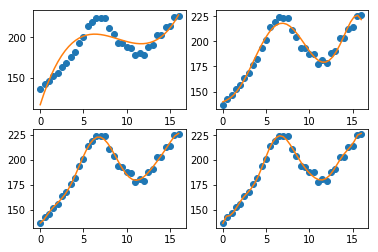

#Testing problem 5:
True
#Testing problem 6:
la.eig(A) == qr_algorithm(A)?
[ 5.76438019+0.j -1.07513200+0.j -0.53279450+0.j  0.90485879+0.j
  0.70748367+0.j  0.44050947+0.j]
[ 5.76438019 -1.075132    0.90485879  0.70748367 -0.5327945   0.44050947]
True


In [8]:
print("#Testing problem 3:")
path = "/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/LeastSquares_Eigenvalues/"
housing = np.load(path + "housing.npy")
a = housing[:, 0]
b = housing[:, 1]
z = np.linspace(0, 16, 40)
#Plot the data against the 3-power least squares estimate
plt.subplot(221)
plt.plot(housing[:,0], housing[:,1], 'o')
c = np.poly1d(np.polyfit(a, b, 3))
plt.plot(z, c(z))
# Ditto; 6-power
plt.subplot(222)
plt.plot(housing[:,0], housing[:,1], 'o')
c = np.poly1d(np.polyfit(a, b, 6))
plt.plot(z, c(z))
#Ditto; 9-power
plt.subplot(223)
plt.plot(housing[:,0], housing[:,1], 'o')
c = np.poly1d(np.polyfit(a, b, 9))
plt.plot(z, c(z))
#Ditto; 12-power
plt.subplot(224)
plt.plot(housing[:,0], housing[:,1], 'o')
c = np.poly1d(np.polyfit(a, b, 12))
plt.plot(z, c(z))

plt.show()


print("#Testing problem 5:")
A = np.random.random((10, 10))
eig, vec = power_method(A)

print(np.allclose(A@vec, eig*vec))

print("#Testing problem 6:")
A = np.random.random((6,6))
A = A + A.T
print("la.eig(A) == qr_algorithm(A)?")
print(la.eig(A)[0], qr_algorithm(A, 2000), sep='\n')
print("True")